# One-Shot Learning Training and Prediction Results

reference:   
[1] https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a   
[2] https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18   
[3] Li Fei-Fei, R. Fergus and P. Perona, "One-shot learning of object categories," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 28, no. 4, pp. 594-611, April 2006, doi: 10.1109/TPAMI.2006.79.

In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
# from torch_utils import *
from oneshot import *


# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



To keep as consistent as possible with the reference article, let's observe the following excerpt:

> Batch Size: Since we are learning how similar are two images, the batch size needs to be pretty big in order for the model to be generalisable especially for a dataset like this with many different categories. Therefore we used a batch size of 128.   
>
> Learning Rate: We tested with several learning rates from 0.001 to 0.0005, and selected a 0.0006 which provided the best loss decreasing rate.   
>
> Optimizer and Loss: We adopted the traditional Adam optimizer for this network with the binary cross entropy (BCE) loss with logits.

Another excerpt from the article that will drive design decisions:
... could be due to the fact that the kernel size of the convolutional layers is fairly small (3x3), which gives a small receptive field. For a problem of computing similarity between two images, it may perhaps be beneficial to look at a “bigger picture” of the two images instead of focusing on small details, and hence a larger receptive field proposed in the original network worked better.

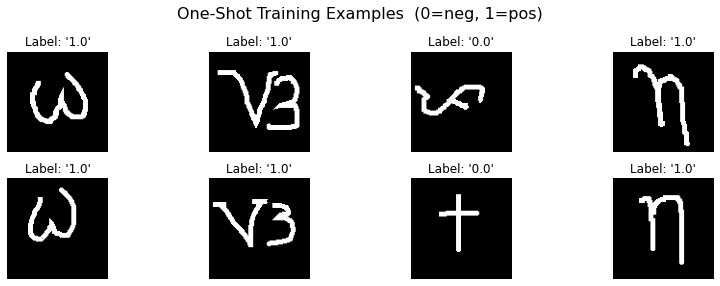

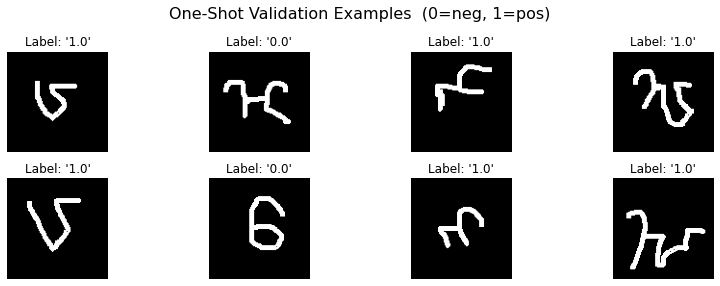

In [11]:
# Hperparameters
BATCH_SIZE = 32
SET_SIZE = 1000 # one-shot,SET_SIZE # of pairs
LR = 0.00006 # per references 1 and 2

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

data_dir='../../data'
train_categories = ['Greek','Tagalog','Latin']
# use helper to create the dataloaders
train_set = OmniglotDataset(root=data_dir, set_size=SET_SIZE, 
                            categories=train_categories,
                            train=True, download=True, 
                            transform=data_transforms['train'])

test_categories = ['Mongolian']
val_set = OmniglotDataset(root=data_dir, set_size=SET_SIZE, 
                            categories=test_categories,
                            train=False, download=True, 
                            transform=data_transforms['val'])


# make the dataloader
dataloaders = {}
image_datasets = {'train':train_set, 'val':val_set}
for x in image_datasets:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
# collect the dataset size and class names
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
class_names = image_datasets['train'].classes

# # preview the dataset
oneshot_dataset_preview(dataloaders['train'], 'One-Shot Training Examples')
print("\n"*2)
oneshot_dataset_preview(dataloaders['val'], 'One-Shot Validation Examples')

In [12]:
# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes this should
# be well suited. DO NOT PRETRAIN FOR BASE MODEL.
model = SiameseNet()

# 
output_dir='output'
num_epochs = 50
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged

# move model to the GPU
cudnn.benchmark = True

criterion = nn.BCEWithLogitsLoss() # binary cross entropy
optimizer = Adam(model.parameters(), lr = LR)

# use helper function to train the model (outputs model and Pandas DF)
print(f'\nTraining One-shot model')
model, omniglot_df,_ = train_oneshot(device, model, dataloaders, dataset_sizes, 
                                     criterion=criterion,optimizer=optimizer, 
                                    output_dir=output_dir, num_epochs=num_epochs)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'oneshot_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
omniglot_df.to_csv(os.path.join(output_dir,results_file),
                  columns=omniglot_df.columns)
print(f'> Saved results to \'{results_file}\'.')


Training One-shot model

Epoch 0/49
----------
Train Loss: 0.647 Train Acc: 0.6875
Val Loss: 0.6391 Val Acc: 0.5938
---------|9
Epoch 10/49
----------
Train Loss: 0.3369 Train Acc: 0.9688
Val Loss: 0.5082 Val Acc: 0.75
---------|19
Epoch 20/49
----------
Train Loss: 0.251 Train Acc: 0.9688
Val Loss: 0.5653 Val Acc: 0.7188
---------|29
Epoch 30/49
----------
Train Loss: 0.1786 Train Acc: 0.9688
Val Loss: 0.4641 Val Acc: 0.9375
---------|39
Epoch 40/49
----------
Train Loss: 0.1613 Train Acc: 1.0
Val Loss: 0.4803 Val Acc: 0.9062
--------|48
Epoch 49/49
----------
Train Loss: 0.1314 Train Acc: 0.9375
Val Loss: 0.5247 Val Acc: 0.8438
Finished Training
Training complete in 1.0m 22.82303285598755s
Best val Acc: 1.0
> Saved results to 'oneshot_results_2020-12-16T071704.csv'.


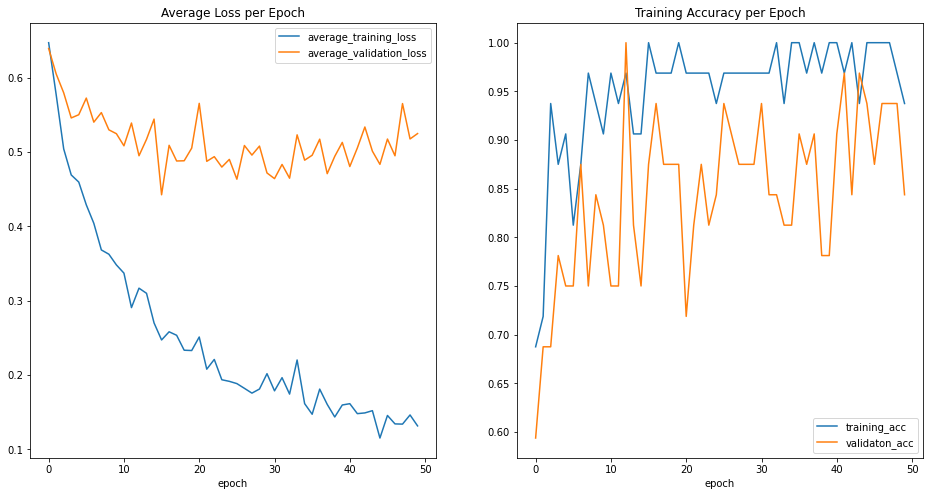

         training_time  validation_time
model                                  
oneshot      56.960846        25.859393



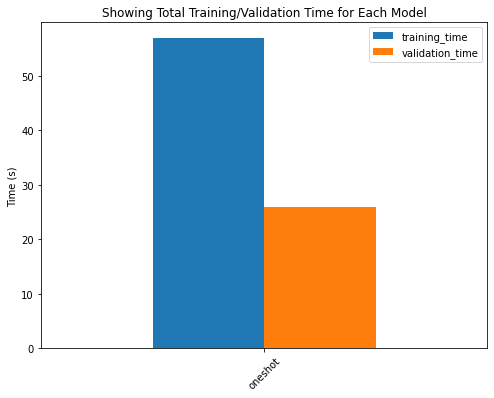

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
omniglot_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
# axes[0].set_ylim([0,3])
omniglot_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuracy per Epoch')

img_file = f'loss_oneshot-omniglot_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

plt.show()

## Compare all of the training/validation times
df = omniglot_df.set_index('epoch').copy()
df['model'] = 'oneshot'
# concatenetate all model results and sum up the times
time_df = df.groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig = time_df.plot.bar(figsize=(8,6)).get_figure()
plt.title('Showing Total Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()
img_file = f'time_oneshot-omniglot__{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))


https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a#bc   

In a Siamese network, a single number is output from the model. This number represents how similar the two inputs are, where a larger number implies that the two images are more similar.

In other words, if the current iteration is an odd number, we retrieve a pair of images from the same character, and vice versa. This ensures that our training dataset is balanced for both types of outputs.

## Training Siamese Network
The Siamese network we chose to use was designed for the Omniglot dataset, a 1-channel dataset well known to be used for one-shot learning. The difference is that the MNIST has images of size 28x28 while the Omniglot has images of size 105x105. As such, we chose to resize our inputs to 105x105 to take full advantage of the established network. Both references below chose to use the Admam optimizer and binary cross entropy with a sigmoid output for the network (since our classes are 1=positive set, 0=negative set). An alternative loss function that might be considered is the [triplet loss](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html) function. 

References:   
[1] https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a#bc
[2] https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d 

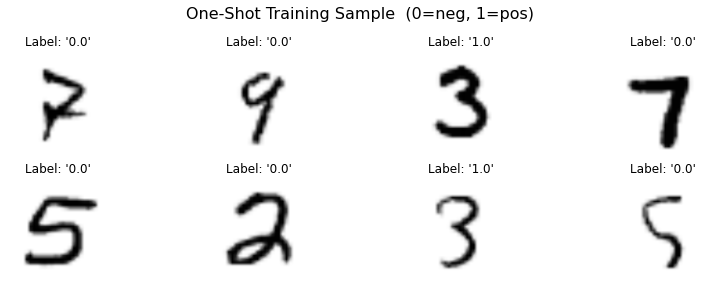

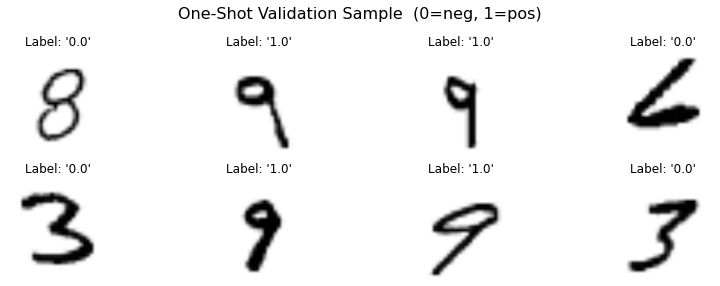

In [6]:
# Hperparameters
BATCH_SIZE = 32
SET_SIZE = 1000 # one-shot,SET_SIZE # of pairs
LR = 0.00006 # per references 1 and 2


# images are 28x28, network expects 105x105
# lets resize to 84 (triple) and add padding (21)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(105),
#         transforms.Resize(84),
#         transforms.Pad(21),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(105),
#         transforms.Resize(84),
#         transforms.Pad(21),        
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

data_dir='../../data'
train_positive = 3
# use helper to create the dataloaders
train_set = OneShotMNIST(root=data_dir, set_size=SET_SIZE, 
                                    positive_class=train_positive,
                                    train=True, download=True, 
                                    transform=data_transforms['train'])

test_positive = 9
val_set = OneShotMNIST(root=data_dir, set_size=SET_SIZE,
                                    positive_class=test_positive,
                                    train=False, download=True, 
                                    transform=data_transforms['val'])


# make the dataloader
dataloaders = {}
image_datasets = {'train':train_set, 'val':val_set}
for x in image_datasets:
    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
# collect the dataset size and class names
dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
class_names = image_datasets['train'].classes

# # preview the dataset
oneshot_dataset_preview(dataloaders['train'],'One-Shot Training Sample')
oneshot_dataset_preview(dataloaders['val'],'One-Shot Validation Sample')

In [7]:
# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes this should
# be well suited. DO NOT PRETRAIN FOR BASE MODEL.
# model = SimpleSiameseNet()
model = SiameseNet()


# 
output_dir='output'
num_epochs = 50
#     == We must changet the last fully connected layer to match 10 classes
# keep features unchanged

# move model to the GPU
cudnn.benchmark = True

# show the model
# print(model)
# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # binary cross entropy
optimizer = Adam(model.parameters(), lr = LR)
# criterion = nn.TripletMarginLoss(margin = 1, p = 1) # https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html
# use helper function to train the model (outputs model and Pandas DF)
print(f'\nTraining One-shot model')
# model, results_df,_ = train_oneshot(device, model, dataloaders, dataset_sizes
model, results_df,_ = train_oneshot(device, model, dataloaders, dataset_sizes,                                    
                                    criterion=criterion,optimizer=optimizer, 
                                    output_dir=output_dir, num_epochs=num_epochs)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'oneshot_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
results_df.to_csv(os.path.join(output_dir,results_file),
                  columns=results_df.columns)
print(f'> Saved results to \'{results_file}\'.')


Training One-shot model

Epoch 0/49
----------
Train Loss: 0.4057 Train Acc: 1.0
Val Loss: 0.9138 Val Acc: 0.2188
---------|9
Epoch 10/49
----------
Train Loss: 0.0032 Train Acc: 1.0
Val Loss: 2.0593 Val Acc: 0.125
---------|19
Epoch 20/49
----------
Train Loss: 0.0009 Train Acc: 1.0
Val Loss: 2.3798 Val Acc: 0.0625
---------|29
Epoch 30/49
----------
Train Loss: 0.0004 Train Acc: 1.0
Val Loss: 2.6477 Val Acc: 0.0312
---------|39
Epoch 40/49
----------
Train Loss: 0.0002 Train Acc: 1.0
Val Loss: 2.7966 Val Acc: 0.125
--------|48
Epoch 49/49
----------
Train Loss: 0.0002 Train Acc: 1.0
Val Loss: 2.9045 Val Acc: 0.0625
Finished Training
Training complete in 1.0m 19.04099154472351s
Best val Acc: 0.2188
> Saved results to 'oneshot_results_2020-12-16T062842.csv'.


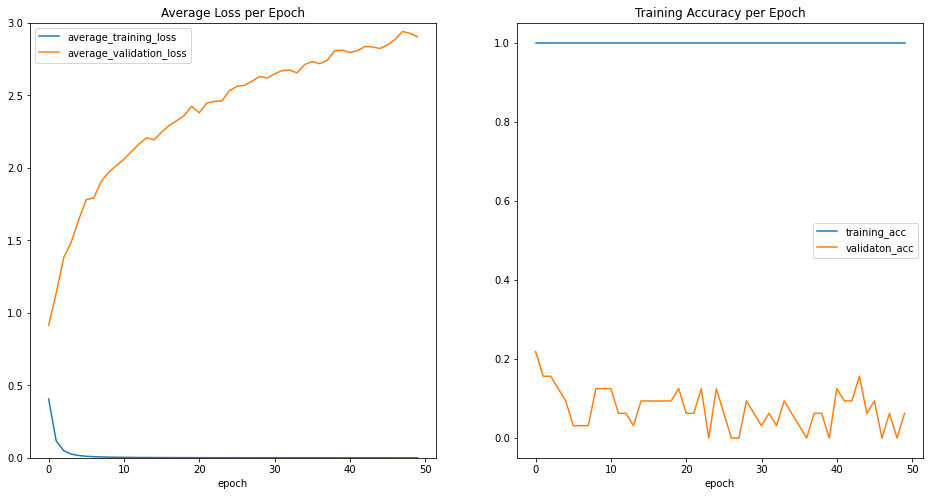

         training_time  validation_time
model                                  
oneshot      55.303424        23.735067



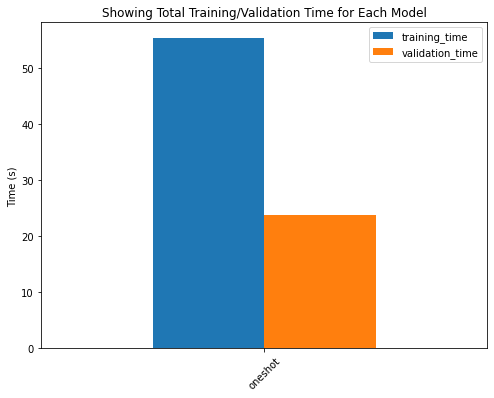

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
results_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
results_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuracy per Epoch')

img_file = f'loss_oneshot-mnist_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))

plt.show()

## Compare all of the training/validation times
df = results_df.set_index('epoch').copy()
df['model'] = 'oneshot'
# concatenetate all model results and sum up the times
time_df = df.groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig = time_df.plot.bar(figsize=(8,6)).get_figure()
plt.title('Showing Total Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()
img_file = f'time_oneshot-mnist_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(output_dir,img_file))


### TODO: 
1. need to figure out why training is diverging
   * Possibly data is not being generated correclty, [1] claims the data should be +/+ and -/- pairs, but it would make more sense to be +/+ and +/-
2. need to implement N-way oneshot evaluation to evaluate